# Fit global epistasis models to DMS expression data

The [`dms_variants.globalepistasis`](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis) module is based off the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) -- that there exists an underlying latent phenotype that mutations affect additively, and
then an observed (measured) phenotype that is a non-linear
function of the latent phenotype.


## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import os
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

import yaml

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.6.0


Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

### Parameters for notebook
Read the configuration file:

In [6]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed:

In [7]:
os.makedirs(config['global_epistasis_expr_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

## Read in Sort-seq expression mean fluorescence scores by `barcode`
Read in Sort-seq expression measurements. I will first fit global epistasis models using the ML_meanF measurements. Rename meanF column to be func_score, and var column to func_score_var. Remove rows with NaN for func_score. For empty aa_substitutions (wildtype), it is being replaced with NA. Make back to an empty string.

In [8]:
df = pd.read_csv(config['expression_sortseq_file'])
df.rename(columns={'delta_ML_meanF':'func_score','var_ML_meanF':'func_score_var'},inplace=True)
func_scores = df[pd.notnull(df['func_score'])]
func_scores.fillna('',inplace=True)
func_scores.head()

,Unnamed: 0,library,target,barcode,variant_call_support,total_count,ML_meanF,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions
1,2,lib1,SARS-CoV-2,AAAAAAAAACTTAAAT,2,64.705656,7.446290,-3.013613,0.040136,>1 nonsynonymous,N13S L60P K94N S147T C150Y,5
2,3,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,117.957762,7.922417,-2.537486,0.025298,>1 nonsynonymous,A22C R127G E141D L188V,4
3,4,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,244.344927,8.934568,-1.525336,0.014454,1 nonsynonymous,N13F,1
4,5,lib1,SARS-CoV-2,AAAAAAAACAATATAA,1,95.352707,6.210683,-4.249221,0.029793,>1 nonsynonymous,C6K T15W K94Y V103W,4
5,6,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,212.429040,7.728388,-2.731516,0.016096,>1 nonsynonymous,V71K P149L N157T,3


## Fit global epistasis models to ML meanF
We now fit global epistasis models to the functional scores.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it.

In [9]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(epistasistype, likelihoodtype, sample, lib)`

for (lib), scores in func_scores.groupby(['library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, lib)] = model

Fitting global epistasis with Gaussian likelihood model to lib1... fitting took 123.4 sec.
Fitting no epistasis with Gaussian likelihood model to lib1... fitting took 0.5 sec.
Fitting global epistasis with Cauchy likelihood model to lib1... fitting took 380.1 sec.
Fitting no epistasis with Cauchy likelihood model to lib1... fitting took 4.0 sec.
Fitting global epistasis with Gaussian likelihood model to lib2... fitting took 114.2 sec.
Fitting no epistasis with Gaussian likelihood model to lib2... fitting took 0.4 sec.
Fitting global epistasis with Cauchy likelihood model to lib2... fitting took 435.9 sec.
Fitting no epistasis with Cauchy likelihood model to lib2... fitting took 3.8 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better:

In [10]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, lib), model in models.items()],
            columns=['model', 'likelihood type', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['library'])
    )

logliks_df.round(1)

,model,likelihood type,n_parameters,log_likelihood,AIC
library,,,,,
lib1,global epistasis,Gaussian,4003,-61495.7,130997.5
lib1,no epistasis,Gaussian,3997,-106497.2,220988.4
lib1,global epistasis,Cauchy,4003,-44719.1,97444.3
lib1,no epistasis,Cauchy,3997,-117045.5,242085.0
lib2,global epistasis,Gaussian,4002,-58140.0,124284.1
lib2,no epistasis,Gaussian,3996,-98801.1,205594.2
lib2,global epistasis,Cauchy,4002,-40875.7,89755.4
lib2,no epistasis,Cauchy,3996,-108529.0,225050.1


In [11]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df
        .reset_index()
        .pivot_table(index=['library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
        ['global_better']
        .all()
        )

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis models fit so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) models, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.

In [12]:
# NBVAL_IGNORE_OUTPUT

variants_df = pd.concat(
        [model.phenotypes_df
         .assign(library=lib,
                 likelihoodtype=likelihoodtype,
                 )
         for (epistasistype, likelihoodtype, lib), model in models.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

#predictionsfile = os.path.join(config['global_epistasis_expr_dir'], 'globalepistasis_expression_predictions.csv')
#variants_df.to_csv(predictionsfile, index=False)
#print(f"Writing predictions to {predictionsfile}")

variants_df.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype
0,N13S L60P K94N S147T C150Y,-3.01,0.04,-0.49,-2.89,lib1,Gaussian
1,A22C R127G E141D L188V,-2.54,0.03,-0.20,-2.31,lib1,Gaussian
2,N13F,-1.53,0.01,-0.15,-1.92,lib1,Gaussian
3,C6K T15W K94Y V103W,-4.25,0.03,-3.26,-3.14,lib1,Gaussian
4,V71K P149L N157T,-2.73,0.02,-0.31,-2.84,lib1,Gaussian


Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

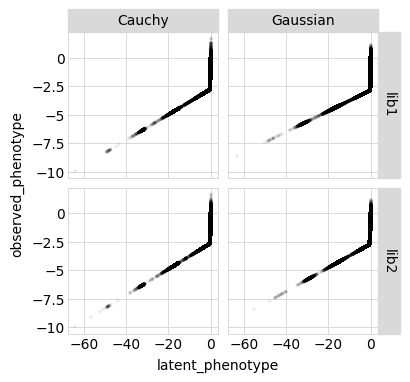

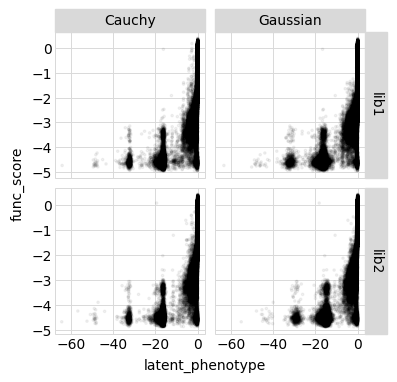

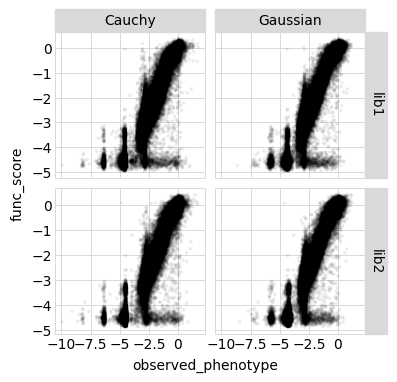

In [13]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

Shape seems pretty consistent between the two likelihood models. There are a fair number of points in the lower-right of the plots showing measured phenotype ("func_score") versus latent or predicted/observed phenotype, indicative of "false negatives" (that is, the model thinks they should be ~high expression, but experimentally, they were non-expressing). This is consistent with what I saw in the previous R script -- a handful of WT variants that had low expression, even with high sequencing counts (so, not noise). Some of these had high variant call support in PacBio sequencing, so they are likely veritable "WT" sequences -- I am assuming that they accrued mutations outside of the PacBio sequencing region (e.g. the 5' Gibson junction or elsewhere) and are therefore truly nonexpressing, though not by virtue of their scFv genotype. It is therefore actually a *good* sign that the model is finding these points, and saying they actually do have high latent phenotypes despite their poor experimental expression.

To get a better view into the "shape" of global epistasis, let's re-make the plots above but only showing single mutant barcodes.

In [14]:
mask = (variants_df['aa_substitutions'].str.len() < 6) & (variants_df['aa_substitutions'].str.len() > 0)
single_variants_df = variants_df.loc[mask]
single_variants_df.head()

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,library,likelihoodtype
2,N13F,-1.525336,0.014454,-0.154924,-1.919413,lib1,Gaussian
6,S184H,-4.664384,0.009626,-0.030524,-0.400302,lib1,Gaussian
14,P7S,-0.067936,0.028029,-0.016311,-0.184446,lib1,Gaussian
27,P149Q,0.041738,0.015011,-0.022495,-0.279410,lib1,Gaussian
30,D90Y,-0.884499,0.048385,-0.095132,-1.273483,lib1,Gaussian


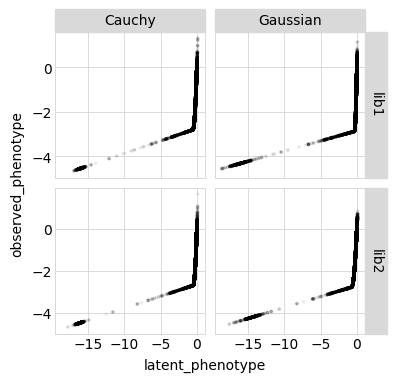

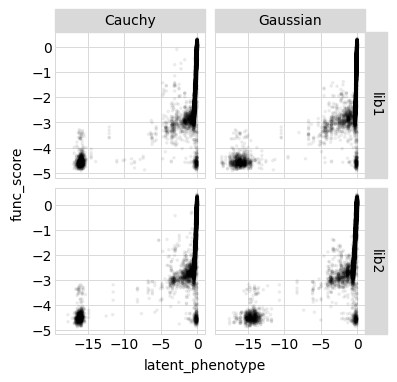

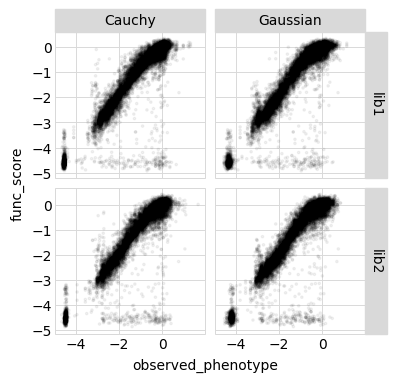

In [15]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(single_variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ likelihoodtype', scales='free_y') +
        theme(figure_size=(2 * variants_df['likelihoodtype'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()

In [16]:
#add predicted and latent phenotypes to table by barcode with additional columns used for interpretation
dt = pd.read_csv(config['expression_sortseq_file'])
dt[['aa_substitutions']] = dt[['aa_substitutions']].fillna(value='')

dt = models.get(('global epistasis', 'Gaussian','lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_1',observed_phenotype_col='predicted_phenotype_Gaussian_1',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 'lib1')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_1',observed_phenotype_col='predicted_phenotype_Cauchy_1',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Gaussian', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Gaussian_2',observed_phenotype_col='predicted_phenotype_Gaussian_2',unknown_as_nan=True)
dt = models.get(('global epistasis', 'Cauchy', 'lib2')).add_phenotypes_to_df(df=dt, substitutions_col='aa_substitutions',latent_phenotype_col='latent_phenotype_Cauchy_2',observed_phenotype_col='predicted_phenotype_Cauchy_2',unknown_as_nan=True)

dt.to_csv(config['global_epistasis_expr_file'], index=False)
print(f"Writing predictions to {config['global_epistasis_expr_file']}")

Writing predictions to results/global_epistasis_expression/global_epistasis_expression_predictions.csv


## Repeat fits for pooled library measurements

Repeat the fits for all barcodes pooled together. There is slight variation in the average mean fluorescence ascribed to wildtype genotypes in each library. 

In [17]:
df_joint = pd.read_csv(config['expression_sortseq_file'])
df_joint.rename(columns={'delta_ML_meanF':'func_score','var_ML_meanF':'func_score_var'},inplace=True)
func_scores_joint = df_joint[pd.notnull(df_joint['func_score'])]
func_scores_joint.fillna('',inplace=True)
func_scores_joint.head()

,Unnamed: 0,library,target,barcode,variant_call_support,total_count,ML_meanF,func_score,func_score_var,variant_class,aa_substitutions,n_aa_substitutions
1,2,lib1,SARS-CoV-2,AAAAAAAAACTTAAAT,2,64.705656,7.446290,-3.013613,0.040136,>1 nonsynonymous,N13S L60P K94N S147T C150Y,5
2,3,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,117.957762,7.922417,-2.537486,0.025298,>1 nonsynonymous,A22C R127G E141D L188V,4
3,4,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,244.344927,8.934568,-1.525336,0.014454,1 nonsynonymous,N13F,1
4,5,lib1,SARS-CoV-2,AAAAAAAACAATATAA,1,95.352707,6.210683,-4.249221,0.029793,>1 nonsynonymous,C6K T15W K94Y V103W,4
5,6,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,212.429040,7.728388,-2.731516,0.016096,>1 nonsynonymous,V71K P149L N157T,3


In [18]:
# NBVAL_IGNORE_OUTPUT

models_joint = {}  # store models, keyed by `(epistasistype, likelihoodtype)`

for (target), scores in func_scores_joint.groupby(['target']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models_joint[(epistasistype, likelihoodtype)] = model



Fitting global epistasis with Gaussian likelihood model... fitting took 221.3 sec.
Fitting no epistasis with Gaussian likelihood model... fitting took 0.9 sec.
Fitting global epistasis with Cauchy likelihood model... fitting took 769.8 sec.
Fitting no epistasis with Cauchy likelihood model... fitting took 5.5 sec.


In [19]:
# NBVAL_IGNORE_OUTPUT

variants_df_joint = pd.concat(
        [model.phenotypes_df
         .assign(likelihoodtype=likelihoodtype)
         for (epistasistype, likelihoodtype), model in models_joint.items()
         if (epistasistype == 'global epistasis')],
        ignore_index=True, sort=False)

variants_df_joint.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,likelihoodtype
0,N13S L60P K94N S147T C150Y,-3.01,0.04,-0.83,-2.85,Gaussian
1,A22C R127G E141D L188V,-2.54,0.03,-0.33,-2.17,Gaussian
2,N13F,-1.53,0.01,-0.28,-1.94,Gaussian
3,C6K T15W K94Y V103W,-4.25,0.03,-5.59,-3.31,Gaussian
4,V71K P149L N157T,-2.73,0.02,-0.61,-2.83,Gaussian


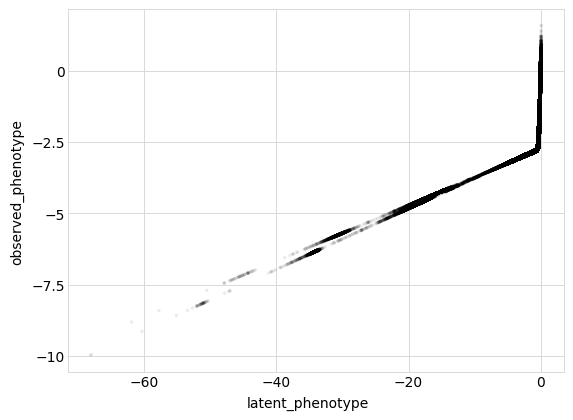

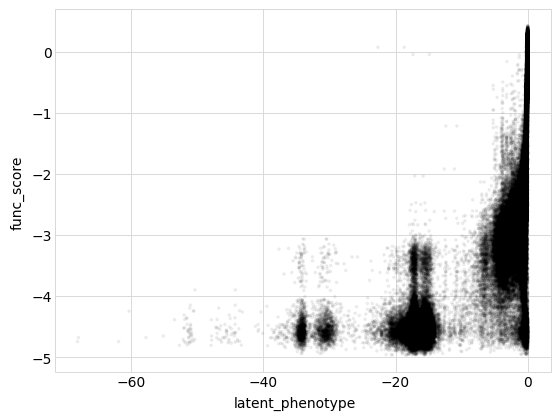

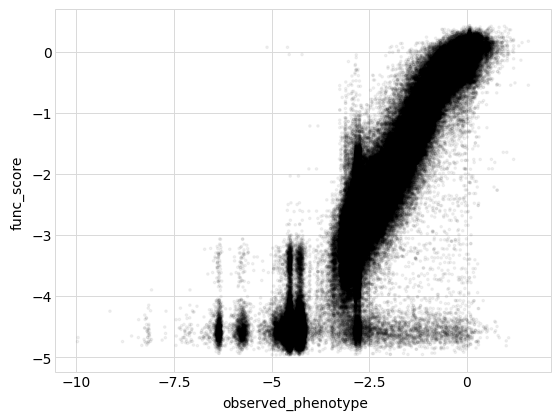

In [20]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df_joint, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5))
#        facet_grid('likelihoodtype', scales='free_y') +
#        theme(figure_size=(2 * variants_df_novar['likelihoodtype'].nunique()),
#              )
#        )
#         plotfile = os.path.join(config['figs_dir'], f'{y}-v-{x}_by_{epistasistype}.pdf')
#         print(f"Saving to {plotfile}")
#         p.save(plotfile)
    _ = p.draw()
    


## Output epistasis model parameters

In [21]:
#lib1 models
models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_1.csv',index=False)
models.get(('global epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_1.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_1.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_1.csv',index=False)
models.get(('no epistasis', 'Gaussian', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_1.csv',index=False)
models.get(('no epistasis', 'Cauchy', 'lib1')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_1.csv',index=False)
#lib2 models
models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_2.csv',index=False)
models.get(('global epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_2.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_2.csv',index=False)
models.get(('global epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_2.csv',index=False)
models.get(('no epistasis', 'Gaussian', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_2.csv',index=False)
models.get(('no epistasis', 'Cauchy', 'lib2')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_2.csv',index=False)
#joint models
models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-latent-effects_expression_joint.csv',index=False)
models_joint.get(('global epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Gaussian-predicted-effects_expression_joint.csv',index=False)
models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='latent',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-latent-effects_expression_joint.csv',index=False)
models_joint.get(('global epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/Cauchy-predicted-effects_expression_joint.csv',index=False)
models_joint.get(('no epistasis', 'Gaussian')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Gaussian-predicted-effects_expression_joint.csv',index=False)
models_joint.get(('no epistasis', 'Cauchy')).single_mut_effects(phenotype='observed',standardize_range=False).to_csv('results/global_epistasis_expression/nonepistatic-Cauchy-predicted-effects_expression_joint.csv',index=False)




In [22]:
#! jupyter nbconvert --to markdown global_epistasis_expression.ipynb --output-dir ./results/summary/ --output global_epistasis_expression.md